# First lab assignment WUM
**Author: Patrycja Ziemkiewicz**

## Data & library imports

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import statsmodels.api as sm
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.cluster import hierarchy
import seaborn as sns

### Assignment

The full problem statement for this lab can be found in the PDF linked below:

[First Lab Assignment (WUM)](https://github.com/patrycja-ziemkiewicz/MIMUW/blob/main/IV%20semester/Machine%20learning/First%20assigment/First%20lab%20assignment%20WUM.pdf)

In [108]:
url = 'https://raw.githubusercontent.com/patrycja-ziemkiewicz/MIMUW/refs/heads/main/IV%20semester/Machine%20learning/First%20assigment/earnings.csv'
df = pd.read_csv(url, sep=';')
display(df.head())

,id,base,bonus,overtime_pay,other,sector,section_07,sex,education,contract,age,duration_total,duration_entity,duration_nominal,duration_overtime
0,192064,26651.53,0.0,0.00,0.00,1,3,2,4,1,49,33.03,7.06,1524.15,0.0
1,25495,40168.50,1500.0,0.00,3414.32,1,2,1,1,1,36,10.07,6.01,1562.40,0.0
2,142164,20134.80,0.0,0.00,1700.41,1,2,2,4,1,52,28.08,19.05,1816.00,0.0
3,198034,16475.00,0.0,0.00,1305.00,1,2,2,5,1,55,35.07,11.01,1816.00,0.0
4,144990,34797.60,0.0,1893.35,3118.73,1,2,2,2,1,50,27.00,19.01,722.80,63.0


## Data description ##



The dataset contains 11 000 observations and 14 variables (without 'id'). Among them, five are qualitative (sector, section_07, sex, education, contract), and the rest are quantitative. There appear to be no missing values, since all variables have the correct types (int64 or float64), which indicates there shouldn’t be any missing or irregular data.

In [109]:
df = df.drop(columns=['id'])
display(df.info())
display(df.isna().any())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   base               11000 non-null  float64
 1   bonus              11000 non-null  float64
 2   overtime_pay       11000 non-null  float64
 3   other              11000 non-null  float64
 4   sector             11000 non-null  int64  
 5   section_07         11000 non-null  int64  
 6   sex                11000 non-null  int64  
 7   education          11000 non-null  int64  
 8   contract           11000 non-null  int64  
 9   age                11000 non-null  int64  
 10  duration_total     11000 non-null  float64
 11  duration_entity    11000 non-null  float64
 12  duration_nominal   11000 non-null  float64
 13  duration_overtime  11000 non-null  float64
dtypes: float64(8), int64(6)
memory usage: 1.2 MB


None

,0
base,False
bonus,False
overtime_pay,False
other,False
sector,False
section_07,False
sex,False
education,False
contract,False
age,False


,base,bonus,overtime_pay,other,sector,section_07,sex,education,contract,age,duration_total,duration_entity,duration_nominal,duration_overtime
0,26651.53,0.0,0.00,0.00,1,3,2,4,1,49,33.03,7.06,1524.15,0.0
1,40168.50,1500.0,0.00,3414.32,1,2,1,1,1,36,10.07,6.01,1562.40,0.0
2,20134.80,0.0,0.00,1700.41,1,2,2,4,1,52,28.08,19.05,1816.00,0.0
3,16475.00,0.0,0.00,1305.00,1,2,2,5,1,55,35.07,11.01,1816.00,0.0
4,34797.60,0.0,1893.35,3118.73,1,2,2,2,1,50,27.00,19.01,722.80,63.0


### Frequency tables and descriptive statistics

For the categorical variables, I created frequency tables showing both the raw counts and their percentage share of the sample. For the numeric variables I used Pandas’ .describe() method to produce summary statistics.

Over 95 % of employees work in the public sector, with more than half (53 %) in education, 25 % in health and social work, and the remainder in public administration. Only around 25 % of the workforce are women. Over 60 % hold a higher‑education degree, and 85 % are employed on indefinite contracts.

Monetary variables (base, bonus, overtime pay, and other) are all highly right‑skewed. In particular, most employees earn zero in overtime pay and other, yet the means remain elevated due to a small number of very large payouts. Similarly, mean base salary and bonuses far exceed their medians, reflecting a long tail of top earners.

Time-related variables (duration total, duration entity, duration nominal, duration overtime) are also skewed, but far less extremely. Typical employees cluster near the lower end of each scale, while a smaller group logs very long tenures or large overtime totals. Age is the most balanced of all variables.


In [93]:
NUMERIC_COLS = [
    'base', 'bonus', 'overtime_pay', 'other',
    'age', 'duration_total', 'duration_entity',
    'duration_nominal', 'duration_overtime'
]

CATEGORICAL_COLS = ['sector','section_07','sex','education','contract']

for col in CATEGORICAL_COLS:
    freq = df[col].value_counts(dropna=False)
    pct  = df[col].value_counts(normalize=True).mul(100).round(1)
    freq_table = pd.DataFrame({'Frequency': freq, 'Percent': pct})
    display(freq_table)


display(df[NUMERIC_COLS].describe())

,Frequency,Percent
sector,,
1,10548,95.9
2,452,4.1


,Frequency,Percent
section_07,,
2,5867,53.3
3,2732,24.8
1,2401,21.8


,Frequency,Percent
sex,,
2,8289,75.4
1,2711,24.6


,Frequency,Percent
education,,
2,6633,60.3
4,1983,18.0
5,906,8.2
3,680,6.2
1,430,3.9
6,368,3.3


,Frequency,Percent
contract,,
1,9306,84.6
2,1694,15.4


,base,bonus,overtime_pay,other,age,duration_total,duration_entity,duration_nominal,duration_overtime
count,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.00000,11000.000000,11000.000000,11000.000000
mean,33376.738065,2128.486176,1679.273923,2477.625815,42.470182,18.56708,11.401382,1301.307435,47.702325
std,19276.551638,4966.444726,5407.964344,3715.419120,10.012140,10.99695,9.322181,540.189234,111.963867
min,10.000000,0.000000,0.000000,0.000000,19.000000,0.01000,0.010000,12.800000,0.000000
25%,20995.115000,0.000000,0.000000,0.000000,34.000000,9.03000,3.070000,766.800000,0.000000
50%,31341.245000,620.000000,0.000000,2141.820000,43.000000,19.03500,9.100000,1591.900000,0.000000
75%,41348.290000,2940.717500,1139.330000,3497.430000,51.000000,27.11000,18.040000,1768.000000,40.000000
max,241624.390000,258061.000000,228110.340000,88555.760000,77.000000,57.02000,46.010000,2024.000000,1812.580000


### Variables distributions

Base, bonus and age all appear roughly normally distributed, as shown in the chart below. Overtime pay, other, duration overtime each feature spike at 0, however their non zero values roughly follow normal distribution. The duration_entity variable follows an exponential‐like decay, and duration_nominal is clearly bimodal—likely reflecting two distinct work patterns (part-time vs. full-time hours).

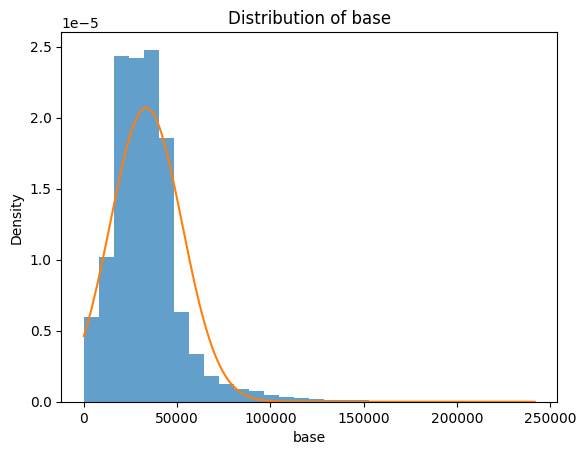

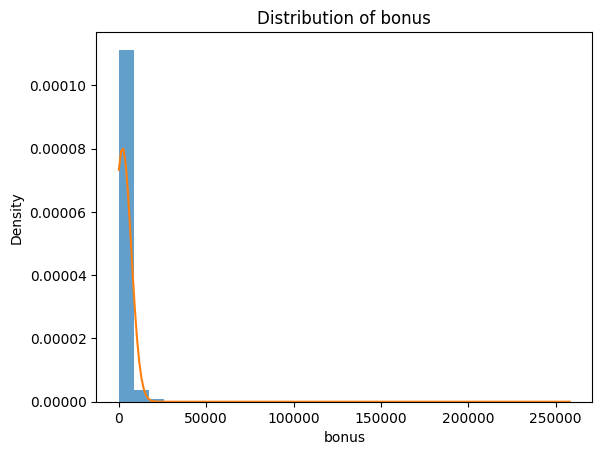

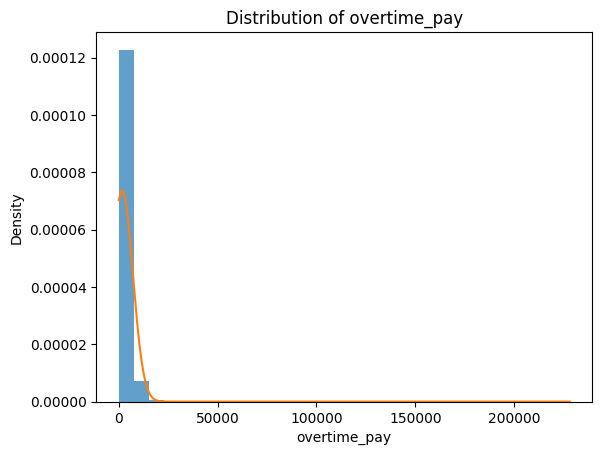

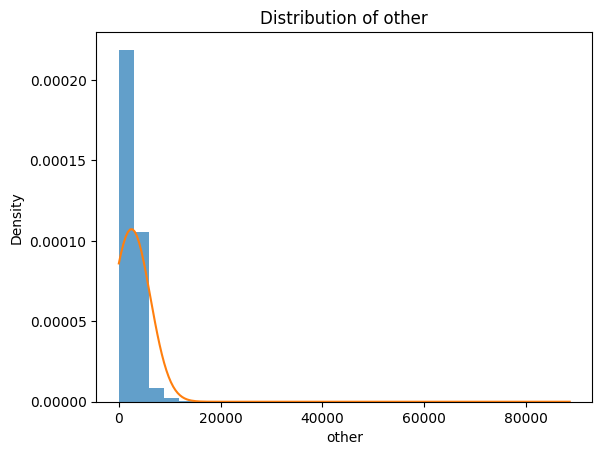

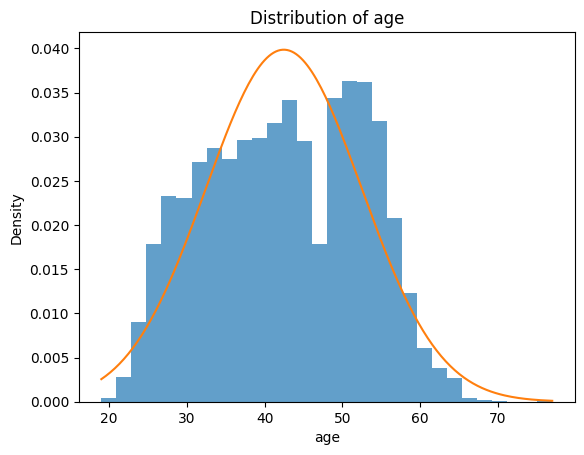

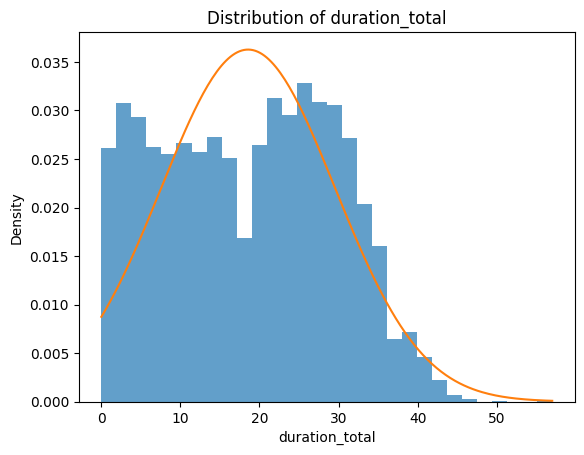

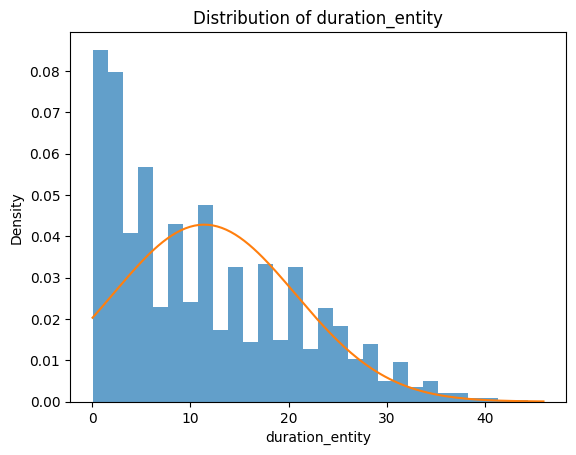

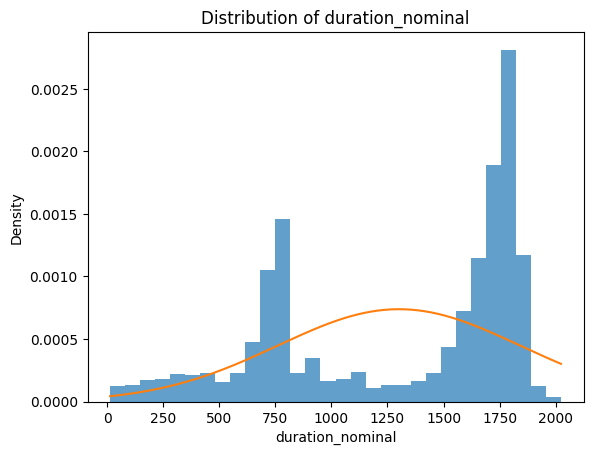

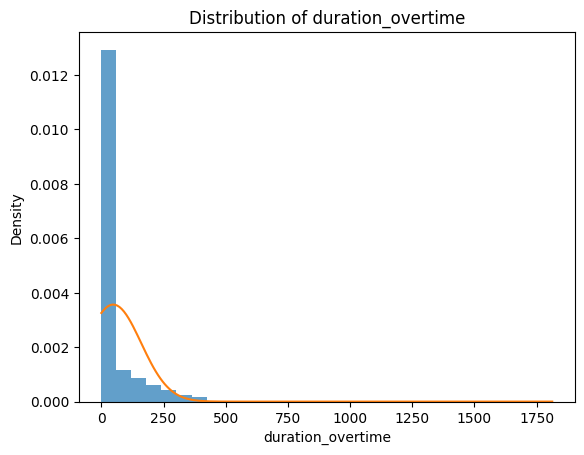

In [94]:
for var in NUMERIC_COLS:
    data = df[var]
    μ, σ = data.mean(), data.std()

    plt.figure()
    plt.hist(data, bins=30, density=True, alpha=0.7)
    x = np.linspace(data.min(), data.max(), 200)
    normal_pdf = 1/(σ * np.sqrt(2*np.pi)) * np.exp(-0.5 * ((x-μ)/σ)**2)
    plt.plot(x, normal_pdf)

    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.show()

## Clustering

### Removing categorical variables

I decided to use K-means and hierarchical clustering with Ward’s linkage which rely on Euclidean distance. I could have one-hot-encoded the categorical columns, but that would introduce several issues:

* explode dimensionality,
* force comparisons between “0/1” indicators and continuous variables,
* makes Euclidean distance less meaningful.

So I stick to purely numeric variables.

### Removing correlated features

A correlation check revealed two almost-duplicate pairs:

* age vs duration_total  –  r ≈ 0.88
* duration overtime vs overtime pay  – r ≈ 0.87

Including both members of a pair would overweight that information in the distance metric. Therefore I left only age and overtime pay and dropped duration total and duration overtime.


,base,bonus,overtime_pay,other,age,duration_total,duration_entity,duration_nominal,duration_overtime
count,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.00000,11000.000000,11000.000000,11000.000000
mean,33376.738065,2128.486176,1679.273923,2477.625815,42.470182,18.56708,11.401382,1301.307435,47.702325
std,19276.551638,4966.444726,5407.964344,3715.419120,10.012140,10.99695,9.322181,540.189234,111.963867
min,10.000000,0.000000,0.000000,0.000000,19.000000,0.01000,0.010000,12.800000,0.000000
25%,20995.115000,0.000000,0.000000,0.000000,34.000000,9.03000,3.070000,766.800000,0.000000
50%,31341.245000,620.000000,0.000000,2141.820000,43.000000,19.03500,9.100000,1591.900000,0.000000
75%,41348.290000,2940.717500,1139.330000,3497.430000,51.000000,27.11000,18.040000,1768.000000,40.000000
max,241624.390000,258061.000000,228110.340000,88555.760000,77.000000,57.02000,46.010000,2024.000000,1812.580000


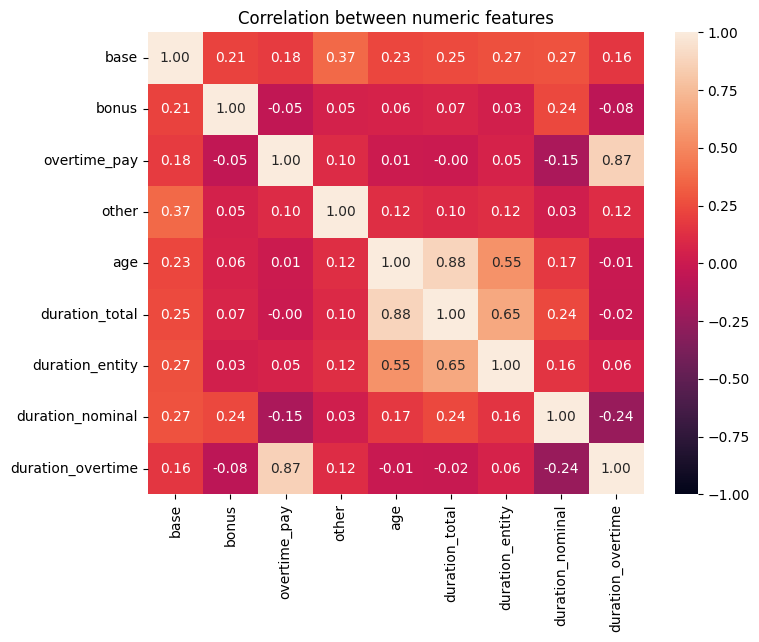

In [95]:
data = df[NUMERIC_COLS].copy()
display(data.describe())

corr = data.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title('Correlation between numeric features')
plt.show()

data = data.drop(columns=['duration_total', 'duration_overtime'])

### Log-transformations

I calculated the skewness coefficient for all numeric variables and found that base, bonus, overtime_pay and other exhibit strong right skew (|skew| > 1). To prevent highly skewed values from disproportionately influencing the clustering, I applied (log(x + 1)) to strongly skewed variables.

### Standarization

After the log step, units are still different  age ≈ 20–60, log(base) ≈ 8–10 etc. StandardScaler puts every feature on the same footing (μ = 0, σ = 1) so that no single variable dominates the Euclidean distance.

In [96]:
display(data.skew())
PAY_COLS = ['base', 'bonus', 'overtime_pay', 'other']

data_log = data.copy()
data_log[PAY_COLS] = np.log1p(data_log[PAY_COLS])
display(data_log.describe())


scaler = StandardScaler()
X = scaler.fit_transform(data_log)

,0
base,2.115708
bonus,17.953570
overtime_pay,15.157801
other,8.821457
age,-0.077343
duration_entity,0.749280
duration_nominal,-0.605821


,base,bonus,overtime_pay,other,age,duration_entity,duration_nominal
count,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000,11000.000000
mean,10.242624,4.520886,2.638775,5.820743,42.470182,11.401382,1301.307435
std,0.657906,3.836822,3.760492,3.499996,10.012140,9.322181,540.189234
min,2.397895,0.000000,0.000000,0.000000,19.000000,0.010000,12.800000
25%,9.952093,0.000000,0.000000,0.000000,34.000000,3.070000,766.800000
50%,10.352722,6.431331,0.000000,7.669878,43.000000,9.100000,1591.900000
75%,10.629811,7.986749,7.039073,8.160070,51.000000,18.040000,1768.000000
max,12.395144,12.460955,12.337589,11.391399,77.000000,46.010000,2024.000000


### K-means clustering

We run K-means for k ∈ [2, 10] and track the average silhouette score.

The highest silhuette score was achieved at k = 4 and it was 0.27. The results are not spectacular hovewer show that clusters are not structured randomly.



In [97]:
sil_scores = []
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(X)
    score = silhouette_score(X, km.labels_)
    sil_scores.append({'k': k, 'silhouette': score})

sil_df = pd.DataFrame(sil_scores)
display(sil_df)

best_km = sil_df.loc[sil_df['silhouette'].idxmax(), 'k']
print(f"\nOptimal number of clusters: {best_km}\n")


,k,silhouette
0,2,0.231649
1,3,0.236870
2,4,0.271247
3,5,0.242636
4,6,0.245047
5,7,0.246882
6,8,0.234278
7,9,0.238957
8,10,0.229888



Optimal number of clusters: 4



### Hierarchical clustering (Ward linkage)

For Hierarchical clustering k = 4, gives the highest average silhouette score 0.26. It is only slightly worse than K-means (0.27).

In [52]:
sil_scores = []
for k in range(2, 11):
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward').fit(X)
    score = silhouette_score(X, agg.labels_)
    sil_scores.append({'k': k, 'silhouette': score})

sil_df = pd.DataFrame(sil_scores)
display(sil_df)

best_agg = sil_df.loc[sil_df['silhouette'].idxmax(), 'k']
print(f"\nOptimal number of clusters: {best_agg}\n")

,k,silhouette
0,2,0.218717
1,3,0.230906
2,4,0.259340
3,5,0.212408
4,6,0.205050
5,7,0.199725
6,8,0.215783
7,9,0.198976
8,10,0.179853



Optimal number of clusters: 4



### Results

| Algorithm | best k | average silhouette |
|-----------|-------:|-------------------:|
| K-means   | 4 | 0.27 |
| Hierarchical clustering (ward method)| 4 | 0.26 |

Both methods do not create a strong cluster structure but it is crearly not random. I will stick with K-means, k = 4 for the final profile because it offers
slightly better separation.

In [98]:
km = KMeans(n_clusters=best_km, random_state=0, n_init='auto').fit(X)
display(pd.Series(km.labels_).value_counts())

print(f"Silhouette score: {silhouette_score(X, km.labels_)}")


,count
0,4178
3,2920
2,2536
1,1366


Silhouette score: 0.2712474207348163


## Classification


### Preparing the Data

First, we convert each categorical variable into one-hot encoded columns, preserving clear interpretability. We then split the dataset into training (70%) and testing (30%) subsets. Since some classifiers (like logistic regression and LDA) assume features are on a comparable numerical scale, we apply a StandardScaler only to the numerical columns. This ensures that the continuous variables have mean = 0 and standard deviation = 1, while the one-hot categorical indicators remain in their original 0/1 form.

In [84]:
data = df.copy()

cat_cols = ['sector', 'section_07', 'sex', 'contract']

y = (data['education'] <= 2).astype(int)
X = data.drop(columns=['education'])

X = pd.get_dummies(X, columns=cat_cols, dtype=int, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler().fit(X_train[NUMERIC_COLS])
X_train[NUMERIC_COLS] = scaler.transform(X_train[NUMERIC_COLS])
X_test[NUMERIC_COLS]  = scaler.transform(X_test[NUMERIC_COLS])


### Cross-Validation Testing
To reliably assess model performance, we use 10-fold cross-validation. This means the training data is partitioned into 10 equal folds; each fold is held out in turn as a validation set while the model is trained on the other nine.

We evaluate three complementary metrics:

* Accuracy, the overall fraction of correct predictions, gives a straightforward success rate but can mask poor performance on minority classes.
* F1-score, the harmonic mean of precision and recall, balances false positives against false negatives—essential when positive and negative classes are imbalanced.
* ROC-AUC, the area under the receiver-operating characteristic curve, measures the model’s ability to rank positive cases higher than negatives across all possible classification thresholds.

In [85]:
cv = 10

def cv_scores(model, Xtr, ytr):
    auc = cross_val_score(model, Xtr, ytr, cv=cv, scoring='roc_auc').mean()
    acc = cross_val_score(model, Xtr, ytr, cv=cv, scoring='accuracy').mean()
    f1  = cross_val_score(model, Xtr, ytr, cv=cv, scoring='f1').mean()
    return auc, acc, f1

### Classification Models

We compare four different algorithms, each with distinct strengths and weaknesses: Logistic Regression, Linear Discriminant Analysis (LDA), Decision Tree, Random Forest.

In [81]:
models = {
    'LogReg': LogisticRegression(),
    'lda': LinearDiscriminantAnalysis(),
    'Tree': DecisionTreeClassifier(max_depth=6, random_state=42),
    'Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=6)
}

for name, clf in models.items():
    auc, acc, f1 = cv_scores(clf, X_train, y_train)
    print(f"{name} AUC={auc}  ACC={acc}  F1={f1}")


LogReg AUC=0.9415555487877587  ACC=0.8684415584415583  F1=0.8967281635312959
lda AUC=0.9324408395658251  ACC=0.8612987012987012  F1=0.8898047990639869
Tree AUC=0.9300187182545375  ACC=0.8653246753246753  F1=0.8939550637155632
Forest AUC=0.9465483924226896  ACC=0.8768831168831168  F1=0.9046736421091068


### Results

After running 10-fold CV on each model, Random Forest consistently achieved the highest scores across ROC-AUC, accuracy, and F1. Consequently, we select Random Forest as our final model.

### Expected perfomance

On test set, Random Forest achieves:
* ROC-AUC: 0.94
* Accuracy: 0.87
* F1-score: 0.90

These numbers closely match our 10-fold cross-validation averages, confirming that the model generalises well.



In [86]:
best_clf = models['Forest']
best_clf.fit(X_train, y_train)

y_prob = best_clf.predict_proba(X_test)[:, 1]
y_pred  = best_clf.predict(X_test)

print("Test ROC-AUC:", roc_auc_score(y_test, y_prob))
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1:", f1_score(y_test, y_pred))

Test ROC-AUC: 0.9443363506311828
Test Accuracy: 0.8715151515151515
Test F1: 0.9033728350045579


### Evaluated importance of different variables

Examining the feature importances, we see that nominal working hours (scheduled hours) is the single strongest predictor of higher education: employees who work more regular hours are more likely to hold an advanced degree.

Compensation-related variables-base and other also rank highly, suggesting that higher-paid individuals tend to be better educated. Furthermore, age and both duration total and duration entity contribute meaningfully, implying that more experienced workers often possess higher qualifications.

All other features have markedly lower influence on the probability of having a higher-level degree.

In [99]:
importances = best_clf.feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

display(feat_imp)

,0
duration_nominal,0.215970
base,0.180771
other,0.149196
duration_total,0.123217
age,0.079031
overtime_pay,0.064517
section_07_3,0.044431
duration_overtime,0.044039
bonus,0.032105
duration_entity,0.029391


## Regression

### Preparing data

During data preparation, I one-hot encoded the categorical features (sector, section_07, sex, education, contract), and split the dataset into training and testing subsets.


In [100]:
data = df.copy()

data = pd.get_dummies(data, columns=CATEGORICAL_COLS, dtype=int, drop_first=True)
display(data.head())

y = data['base']
X = data.drop(columns=['base'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

,base,bonus,overtime_pay,other,age,duration_total,duration_entity,duration_nominal,duration_overtime,sector_2,section_07_2,section_07_3,sex_2,education_2,education_3,education_4,education_5,education_6,contract_2
0,26651.53,0.0,0.00,0.00,49,33.03,7.06,1524.15,0.0,0,0,1,1,0,0,1,0,0,0
1,40168.50,1500.0,0.00,3414.32,36,10.07,6.01,1562.40,0.0,0,1,0,0,0,0,0,0,0,0
2,20134.80,0.0,0.00,1700.41,52,28.08,19.05,1816.00,0.0,0,1,0,1,0,0,1,0,0,0
3,16475.00,0.0,0.00,1305.00,55,35.07,11.01,1816.00,0.0,0,1,0,1,0,0,0,1,0,0
4,34797.60,0.0,1893.35,3118.73,50,27.00,19.01,722.80,63.0,0,1,0,1,1,0,0,0,0,0


### Checking significance

In the full model including all predictors, both sector_2 and section_07_3 showed high p-values, so I conducted a Wald test for their joint insignificance. The test confirmed that they are jointly non-significant (p = 0.29), and I therefore removed them and refit the model.



In [101]:
X_train = sm.add_constant(X_train)
model_full = sm.OLS(y_train, X_train).fit()
print(model_full.summary())

wald_res = model_full.f_test(["sector_2 = 0", "section_07_3 = 0"])
print("Joint p-value:", wald_res.pvalue)

                            OLS Regression Results                            
Dep. Variable:                   base   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     432.4
Date:                Mon, 05 May 2025   Prob (F-statistic):               0.00
Time:                        19:33:06   Log-Likelihood:                -84256.
No. Observations:                7700   AIC:                         1.685e+05
Df Residuals:                    7681   BIC:                         1.687e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.552e+04   1673.66

### Final model  
After removing variables with p-values above 0.05, the final model retains only predictors that are statistically significant (p < 0.001).

All payment-related variables(bonus, overtime_pay, other) have positive coefficients, which means that higher bonuses, overtime pay, and others are associated with increased base salaries. Age, duration_total and variables connected to time spend in the company, also generate positive coefficients which indicates that more expierences employees earn more.

The gender variable has a negative coefficient for women (code 2), reflecting that female employees receive lower base salaries than their male counterparts. Education level displays increasingly negative coefficients as it falls further below the doctorate reference category—employees with the lowest education level face the largest reduction in base pay.

Employees in the education sector (section_07 = 2) earn on average less than those in public administration (the reference sector). Holding a fixed-term contract (contract = 2) is also negatively associated with base pay compared to an indefinite contract.

Finally, the distinction between the private and public economic sector (sector = 1 vs. 2) does not have a meaningful impact on base salary in this model.


In [102]:
X_train_reduced = X_train.drop(columns=['sector_2','section_07_3'])
X_train_reduced = sm.add_constant(X_train_reduced)
model_reduced = sm.OLS(y_train, X_train_reduced).fit()
print(model_reduced.summary())


                            OLS Regression Results                            
Dep. Variable:                   base   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     486.2
Date:                Mon, 05 May 2025   Prob (F-statistic):               0.00
Time:                        19:33:10   Log-Likelihood:                -84257.
No. Observations:                7700   AIC:                         1.685e+05
Df Residuals:                    7683   BIC:                         1.687e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.493e+04   1630.37